In [1]:
import xgboost as xgb
import pickle
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import cv2
import sys
import os
from skimage.metrics import structural_similarity, normalized_root_mse, adapted_rand_error, hausdorff_distance, peak_signal_noise_ratio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from compare_images import compare_images
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv_path = 'train_data.csv'
template_path = 'template'

In [3]:
templates = [(1+i, f, cv2.imread(os.path.join(template_path, f))) for i, f in enumerate(os.listdir(template_path)) if os.path.isfile(os.path.join(template_path, f))]
columns = []
for t in templates:
    columns.extend((
        t[1] + '_similarity',
        t[1] + '_mse',
        #t[1] + '_adapted_rand_error_are',
        #t[1] + '_adapted_rand_error_prec',
        #t[1] + '_adapted_rand_error_rec',
        #t[1] + '_hausdorff_distance',
        #t[1] + '_hpsnr',
    ))
columns.append('label')

In [4]:
def get_row(path, label):
    cols = []
    after = cv2.imread(path)
    for _, template_name, template_image in templates:
        comparison = compare_images(template_image, after)
        cols.extend((
            comparison['similarity'], 
            comparison['mse'],
            #comparison['adapted_rand_error_are'],
            #comparison['adapted_rand_error_prec'],
            #comparison['adapted_rand_error_rec'],
            #comparison['hausdorff_distance'],
            #comparison['psnr'],
        ))
    cols.append(label)
    return cols

rows = []
for root, dirs, files in os.walk('train'):
    if root == 'train':
        continue
    if os.path.basename(root) == 'garbage':
        label = 0
    else:
        label = [t[0] for t in templates if os.path.basename(root) == t[1]][0]

    for f in files:
        rows.append(get_row(os.path.join(root, f), label))

    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(csv_path)

In [5]:
df = pd.read_csv(csv_path)

In [6]:
X = df.drop(['label', 'Unnamed: 0'] + [c for c in columns if
                                       c.endswith('rand_error_prec') or
                                        c.endswith('rand_error_rec') or
                                        c.endswith('rand_error_are') or
                                        c.endswith('hpsnr') or
                                        c.endswith('_hausdorff_distance') or
                                       False
                                      ], axis=1).fillna(0)
y = df['label'].astype(int)

for c in X.columns:
    mask = df[c] != np.inf
    df.loc[~mask, c] = df.loc[mask, c].max()
X

,rubhands.jpg_similarity,rubhands.jpg_mse,expandingbrain4.jpg_similarity,expandingbrain4.jpg_mse,dogapocalypse.webp_similarity,dogapocalypse.webp_mse,Two-Buttons.jpg_similarity,Two-Buttons.jpg_mse,AmericanChopperArgument_vertical.png_similarity,AmericanChopperArgument_vertical.png_mse,...,areyouwinningson.jpg_similarity,areyouwinningson.jpg_mse,spidermanpresentation.jpg_similarity,spidermanpresentation.jpg_mse,leftexitmeme.jpg_similarity,leftexitmeme.jpg_mse,herewegoagain.jpg_similarity,herewegoagain.jpg_mse,fracasado.jpg_similarity,fracasado.jpg_mse
0,0.300937,0.501294,0.178959,0.690593,0.230511,0.636255,0.190340,0.494729,0.159773,0.855226,...,0.332321,0.467065,0.210694,0.882457,0.208677,0.967824,0.185511,1.161793,0.138830,0.861719
1,0.268079,0.479718,0.152092,0.712790,0.199245,0.669085,0.189397,0.511060,0.139478,0.872854,...,0.301846,0.477293,0.187497,0.872519,0.182899,1.011530,0.171406,1.187200,0.129924,0.862486
2,0.370474,0.433283,0.160732,0.719834,0.208676,0.649377,0.196320,0.519817,0.169330,0.840395,...,0.309161,0.480148,0.183022,0.834281,0.177257,0.999564,0.196248,1.142979,0.132398,0.862043
3,0.238855,0.501872,0.175580,0.594166,0.172633,0.592775,0.140297,0.533832,0.128949,0.729208,...,0.230153,0.488293,0.141860,0.807718,0.158472,0.882160,0.157236,0.923969,0.106424,0.759422
4,0.376774,0.478183,0.192321,0.732320,0.225081,0.678817,0.203010,0.538653,0.175548,0.870786,...,0.345351,0.489453,0.232053,0.849640,0.191190,1.036382,0.195667,1.186387,0.151819,0.898931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.182567,0.613749,0.156485,0.609089,0.172893,0.523811,0.125065,0.596183,0.084117,0.725512,...,0.164447,0.629226,0.160475,0.674739,0.170148,0.690501,0.148883,0.739498,0.218792,0.417416
696,0.183030,0.630847,0.159802,0.612159,0.173216,0.550215,0.133519,0.601973,0.086819,0.745636,...,0.172680,0.631623,0.165063,0.686958,0.175825,0.701960,0.157003,0.763519,0.214523,0.450104
697,0.211803,0.586074,0.163141,0.611262,0.179850,0.526871,0.144702,0.587437,0.115595,0.712300,...,0.211261,0.604891,0.185282,0.737337,0.196221,0.677475,0.168451,0.753440,0.133854,0.573722
698,0.161112,0.631456,0.139600,0.640205,0.139974,0.583988,0.114474,0.611860,0.082101,0.734598,...,0.139193,0.629991,0.146333,0.666550,0.147494,0.722557,0.124645,0.789591,0.621362,0.245512


In [7]:
classifier = xgb.XGBClassifier(use_label_encoder=False)
print(cross_val_score(classifier, X, y.values, cv=3))

[09:24:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:28:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.7008547  0.75107296 0.74678112]


In [8]:
classifier.fit(X, y)
pickle.dump(classifier, open(f'classifier-{csv_path}.pickle', "wb"))

[09:36:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
sorted(classifier.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1])


[('trolleyproblem.webp_similarity', 0.11965429874999998),
 ('disappointed.jpg_mse', 0.20041344355555565),
 ('bigdogsmalldog.png_similarity', 0.20285208988749998),
 ('bigdogsmalldog.png_mse', 0.20639855201583335),
 ('wikihowdefending.jpg_similarity', 0.279386134304),
 ('expandingbrain.jpg_similarity', 0.28957517971416674),
 ('awkwardlookpuppet.png_mse', 0.30125770101055),
 ('areyouwinningson.jpg_similarity', 0.3155894540125),
 ('calculating.jpg_similarity', 0.45504157061034484),
 ('changemymind.png_mse', 0.46288527992588235),
 ('tuxedopooh.png_similarity', 0.4728990834578946),
 ('finallyscientist.jpg_similarity', 0.5045916083333333),
 ('ihavefailedyou.png_similarity', 0.5225493386161703),
 ('leftexitmeme.jpg_mse', 0.5386481760558331),
 ('spidermanpresentation.jpg_mse', 0.5749817341589163),
 ('swordsunited.jpg_similarity', 0.6082911971601281),
 ('heman.jpg_mse', 0.64781490448),
 ('swordreveal.jpg_mse', 0.6970615546576922),
 ('trolleyproblem.webp_mse', 0.7050632309588236),
 ('wolveringcru

In [10]:
from sklearn.model_selection import StratifiedKFold
classifiers = []
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=9)
for train, test in kfold.split(X, y):
    classifier = xgb.XGBClassifier(use_label_encoder=False)
    classifier.fit(X.iloc[train], y.iloc[train])
    classifiers.append(classifier)

[09:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
probas = pd.DataFrame([[np.nan, np.nan, np.nan] for _ in range(X.shape[0])], columns=['proba', 'pred', 'real'])
for i, (train, test) in enumerate(kfold.split(X, y)):
    p = classifiers[i].predict_proba(X.iloc[test])
    proba = pd.DataFrame(p).apply(lambda row: pd.Series([row.max(), np.argmax(row), np.nan]), axis=1)
    proba.index = test
    probas.loc[test] = proba

probas.loc[:, 'real'] = y
probas.loc[:, 'pred'] = probas['pred'].astype(int)
probas.loc[:, 'ok'] = probas['pred'] == probas['real']
probas

,proba,pred,real,ok
0,0.717948,0,1,False
1,0.386761,1,1,True
2,0.443504,1,1,True
3,0.214335,0,1,False
4,0.465854,1,1,True
...,...,...,...,...
695,0.849329,49,49,True
696,0.675400,49,49,True
697,0.276582,43,49,False
698,0.723698,49,49,True


In [12]:
probas['proba']

0      0.717948
1      0.386761
2      0.443504
3      0.214335
4      0.465854
         ...   
695    0.849329
696    0.675400
697    0.276582
698    0.723698
699    0.157747
Name: proba, Length: 700, dtype: float64

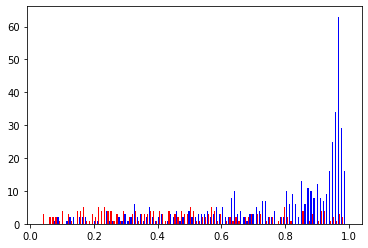

In [13]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
ax.hist([probas[probas['ok']]['proba'], probas[~probas['ok']]['proba']], bins=100, label=probas['ok'], color=[(0, 0, 1), (1, 0, 0)])
None

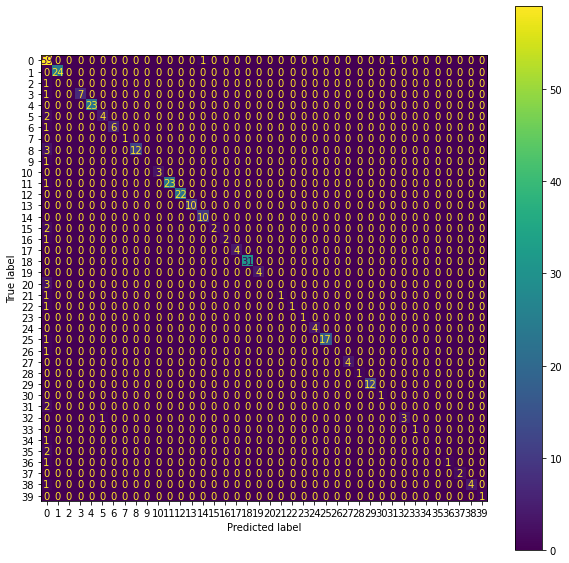

In [14]:
y_pred = probas['pred'][probas['proba'] > 0.8]
y_real = probas['real'][probas['proba'] > 0.8]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(confusion_matrix(y_real, y_pred)).plot(ax=ax)
None